# C0TB1060 蒲原紳乃輔

# 課題レポート
今回は以下の内容を扱ってみる \
1. irisデータの全ての特徴量データを使った分類 (object指向概念の勉強にもなる)
2. 任意ｎ特徴量を選んで点と分類曲線を描く
3. iris以外のデータも扱う(breast_cancer)

今回は実装はもちろんだが、理論もちゃんと説明することにする。

## 4つの特徴量データを用いた分類

* 【中・上級者向け】`DIYClassifier08` を継承したとクラス `fit(X, y)`メソッドを上書きし，よりよい学習器を作ろう．どのようにすれば分類精度が高い `self.a` と `self.b` の組合せが見つかるだろうか？

* 【上級者向け】`DIYClassifier08` は，データ`X`の特徴量が2であることを仮定して設計されている．したがってこのままでは，特徴量を3以上に増やしたり，1つに減らしたりしたときには動作しない．特徴量の数に依らず，正しく動作するように拡張してみよう．


* 【中級者向け】**「丸暗記学習器」**を `MemorizingClassifier` として実装してみよう．`fit(X, y)` の中で，データを丸暗記しておき，`predict(X)` の中では，その記憶通りに答えれば，少なくとも学習時に現れたデータに対して正しく答えられるはずだ．


今まででは特徴量データが2つだけのみを扱っているが、毎回データが2次元とは限らない。そこで、任意の次元に対応できるプログラムを作成する。


>用いるアルゴリズム：単層ニューラルネットワーク



### 理論
確率勾配降下を用いたコスト関数の最小化を目指したアルゴリズム \

以下の記号を導入する \

**X**  特徴量データ (今回は100x4の行列) \
**y**  正解ラベル (今回は0,1のラベルからなる) \
**W**  重み(線形写像) 今回は**W**の最適化を行う \
**b**  バイアス 今回は含めなくてよい \

始めに**X**と**W**の内積を取る \


\begin{equation}
Z  = W・X
\end{equation}

内積を取ったのちに値を0から1に制限するsigmoid関数を作用させる

\begin{equation}
output = \frac{1}{1 + exp(-z)}
\end{equation}

二値問題ではouputが0.5以上では1を返し、それ以外は0を返す \

\begin{equation}
\hat{y}=
    \begin{cases}
        1   &   output \geq 0.5  \\
        0        &   otherwise
    \end{cases}
\end{equation}

次に、重みWの更新の方法について述べる \

損失関数を定義(今回はMSEを使用) \
\begin{equation}
J = \frac{(y - \hat{y})^2}{2}
\end{equation}

そしてJの勾配を求める
\begin{equation}
\nabla{J} = \frac{\partial{J}}{\partial{W}}= \sum_{k}^{n} \frac{y_k - \hat{y_k}}{X.shape[0]} X
\end{equation}
そして、勾配を用いて重みを更新する \
\begin{equation}
W := W - \eta\nabla{J}
\end{equation}
全てのデータを一気に扱い、数回学習を繰り返す

### 実装(iris dataを用いる)

#### データセットの読み込み

In [ ]:
# datasetの読み込み
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 

iris = load_iris()
X = iris.data[iris.target!=2]
y = iris.target[iris.target!=2]
y.shape

(100,)

#### classを定義し分類器の作成

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

class DIYClassifier08( BaseEstimator, ClassifierMixin ):
    """DIY分類器 ver. 0.8
    DIYClassifier07 と同じものを，BaseEstimator と ClassifierMixin から直接継承して書き直した．
    """
    def __init__(self,lr,input_num):
      self.W = np.random.randn(input_num,1)
      self.b = np.zeros([X.shape[0],1])
      self.lr = lr 

    def fit(self, X, y):
      #傾きや切片を表すパラメータと特徴量データの内積にシグモイド関数を作用させる
      #前回のレポートでsigmoid 関数については触れた(0～1の値を返す関数)
      wx = np.dot(X,self.W) + self.b #(100,1)
      self.output = 1 / (1 + np.exp(-wx))
      self.output = self.output.T #(1,100)
      self.output = self.output.reshape(X.shape[0],)

      #コスト関数を定義する(二乗誤差を用いる)
      self.loss = np.sum(0.5 * (y - self.output)**2)

      #コスト関数の勾配を求める
      self.grad = -np.dot(X.T,y - self.output) / X.shape[0] #(1,4)
      self.grad = self.grad.reshape(X.shape[1],1)

      #コスト関数の勾配を用いてパラメーターの更新を行う
      self.W -= self.lr * self.grad 

    def predict(self, X):
      #sigmoid関数で計算した値は0～1の値を取るので、間0.5でクラス0 or クラス1に分類することが可能である
      self.y_pred = np.where(self.output >= 0.5,1,0) 
      return self.y_pred 

上で作った分類器を用いて学習を進める

#### 学習

In [ ]:
list_acc = []
list_loss = []
W_ = []
EPOCH = 30

#インスタンスの定義
model = DIYClassifier08(lr=0.1,input_num=4)

for epoch in range(EPOCH):
  model.fit(X,y)
  #予測値を計算
  y_pred = model.predict(X)
  #損失関数を配列に代入
  list_loss.append(model.loss)

  #正答率を配列に代入する
  score = model.score(X,y)
  list_acc.append(score)

  W_.append(model.W)

  print(f'EPOCH {epoch + 1}/{EPOCH} loss: {np.mean(model.loss)} acc: {100.0*score}% \n')


EPOCH 1/30 loss: 24.1533427544299 acc: 50.0% 

EPOCH 2/30 loss: 20.59869765195395 acc: 32.0% 

EPOCH 3/30 loss: 18.131019386716403 acc: 30.0% 

EPOCH 4/30 loss: 16.87320697844252 acc: 35.0% 

EPOCH 5/30 loss: 15.677385523510832 acc: 38.0% 

EPOCH 6/30 loss: 14.552853527348939 acc: 41.0% 

EPOCH 7/30 loss: 13.500938574546161 acc: 45.0% 

EPOCH 8/30 loss: 12.521463938972262 acc: 52.0% 

EPOCH 9/30 loss: 11.612923790798638 acc: 56.99999999999999% 

EPOCH 10/30 loss: 10.772823610763426 acc: 70.0% 

EPOCH 11/30 loss: 9.997970261243129 acc: 72.0% 

EPOCH 12/30 loss: 9.284714671747697 acc: 75.0% 

EPOCH 13/30 loss: 8.62914833040584 acc: 78.0% 

EPOCH 14/30 loss: 8.027257528175335 acc: 79.0% 

EPOCH 15/30 loss: 7.475040655708003 acc: 82.0% 

EPOCH 16/30 loss: 6.968594271795321 acc: 84.0% 

EPOCH 17/30 loss: 6.504173516044279 acc: 85.0% 

EPOCH 18/30 loss: 6.078231970318346 acc: 87.0% 

EPOCH 19/30 loss: 5.6874454498387035 acc: 91.0% 

EPOCH 20/30 loss: 5.328723532600651 acc: 92.0% 

EPOCH 21/3

#### 結果の分析

おおよそ30回程度でしっかりと正答率が100%近くになってくれることがわかった。次に損失関数と正答率の挙動を示す学習曲線を作成する

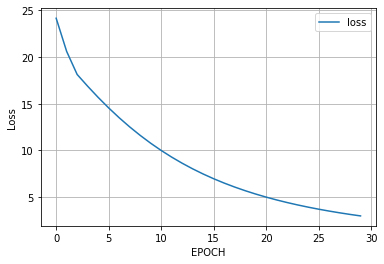

In [ ]:
plt.plot(list_loss,label='loss')
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.grid(True)
plt.show()

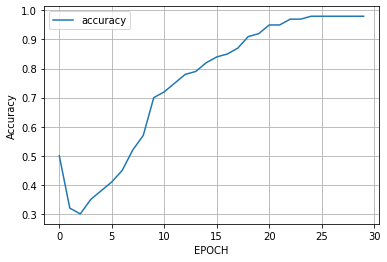

In [ ]:
plt.plot(list_acc,label='accuracy')
plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

念のために予測値と正解値がしっかりと一致していることを示そう

In [ ]:
y == model.predict(X)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

#### データの可視化（二次元に落とし込む)
今回は特徴量データを4つ用いて分類を行った。２つだと二次元平面にプロットできるのだが、4次元だと無理である。そこで、4つある特徴量から2つの組み合わせを考えると Comb(4,2) = 6組の組み合わせができる。\
(1,2) (1,3) (1,4) (2,3) (2,4) (3,4)　

これら6つの特徴量をプロットする


In [ ]:
#境界面のプロット
def plot_decision_regions(x, y, classifier, title,resolution=0.01):
    
  import matplotlib.pyplot as plt 
  import numpy as np 

  # マーカーと色の準備
  markers = ('s', 'x', 'o')
  colors = ('red', 'blue' ,'green')

  # L最大値と最小値を求める
  x_min, x_max = x[:, 0].min() -0.1, x[:, 0].max() +0.1
  # 最大値と最小値を求める
  y_min, y_max = x[:, 1].min() -0.1, x[:, 1].max() +0.1
  # 格子点の座標をresolution(0.01)ごとに取得
  xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution), np.arange(y_min, y_max, resolution))
  # 分類器を使って、zにデータを格納
  z = classifier.predict(np.array([xx.ravel(), yy.ravel()]).T)
  z = z.reshape(xx.shape)

  # 格子点とデータをもとに線をプロット
  plt.contourf(xx, yy, z, alpha=0.1,levels=3,colors=["darkorange","darkblue"])
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

  markers = ('s', 'x')
  colors = ('red', 'blue')
  labels = ['setosa','virsicolor','virginica']

  for i, cl in enumerate(np.unique(y)):
    plt.scatter(x=x[y == cl, 0], y=x[y == cl, 1], alpha=0.8, c=colors[i], marker=markers[i], label=labels[cl],edgecolor="k")

  plt.legend(loc='best')
  plt.title(title)
  plt.xlabel("X")
  plt.ylabel("Y")
  plt.show()

In [ ]:
feature_name = iris.feature_names
target_name = iris.target_names

X1 = X[:,[0,1]]
ttl1 = str(feature_name[0]) + '-' + str(feature_name[1])

X2 = X[:,[0,2]]
ttl2 = str(feature_name[0]) + '-' + str(feature_name[2])

X3 = X[:,[0,3]]
ttl3 = str(feature_name[0]) + '-' + str(feature_name[3])

X4 = X[:,[1,2]]
ttl4 = str(feature_name[1]) + '-' + str(feature_name[2])

X5 = X[:,[1,3]]
ttl5 = str(feature_name[1]) + '-' + str(feature_name[3])

X6 = X[:,[2,3]]
ttl6 = str(feature_name[2]) + '-' + str(feature_name[3])

data = [X1,X2,X3,X4,X5,X6]
ttl = [ttl1,ttl2,ttl3,ttl4,ttl5,ttl6]

for i in range(6):
  model = DIYClassifier08(lr=0.1,input_num=2)
  model.fit(data[i],y)
  plot_decision_regions(data[i],y,classifier=model,title=str(ttl[i]))
  plt.show()

ValueError: ignored

## irisデータ以外も扱ってみる。
上ではirisデータを扱って、分類器を作ってみた。１種類のデータだけで分類器の性能を図ることはできない。よって、他のデータでも試してみたい。

### breast_cancerデータ
digitsの回の課題レポートでbreast_cancerデータをあつかった。特徴量30個に対して、乳がんに罹患しているか否かのデータが記録されている。

まずはデータを呼び出す

In [ ]:
from sklearn.datasets import load_breast_cancer

In [ ]:
breast_cancer = load_breast_cancer()

#特徴量名とターゲット名を得る
feature_names = breast_cancer.feature_names
target_names = breast_cancer.target_names

X = breast_cancer.data
y = breast_cancer.target 

さっそく、上で作った分類器にデータを通してみる。

In [ ]:
list_acc = []
list_loss = []
W_ = []
EPOCH = 500

#インスタンスの定義
model = DIYClassifier08(lr=0.0001,input_num=30)

for epoch in range(EPOCH):
  model.fit(X,y)
  #予測値を計算
  y_pred = model.predict(X)
  #損失関数を配列に代入
  list_loss.append(model.loss)

  #正答率を配列に代入する
  score = model.score(X,y)
  list_acc.append(score)

  W_.append(model.W)

  print(f'EPOCH {epoch + 1}/{EPOCH} loss: {np.mean(model.loss)} \n')

EPOCH 1/500 loss: 106.0 

EPOCH 2/500 loss: 106.0 

EPOCH 3/500 loss: 106.0 

EPOCH 4/500 loss: 106.0 

EPOCH 5/500 loss: 106.00000000001388 

EPOCH 6/500 loss: 109.17730167146779 

EPOCH 7/500 loss: 172.657776606139 

EPOCH 8/500 loss: 248.36866979306637 

EPOCH 9/500 loss: 255.88815054340802 

EPOCH 10/500 loss: 256.5012436871853 

EPOCH 11/500 loss: 249.60680254132185 

EPOCH 12/500 loss: 248.32359259064077 

EPOCH 13/500 loss: 247.4376835642017 

EPOCH 14/500 loss: 245.98411340037234 

EPOCH 15/500 loss: 245.21364410878732 

EPOCH 16/500 loss: 244.91601897004512 

EPOCH 17/500 loss: 244.76647229164678 

EPOCH 18/500 loss: 244.67121917250148 

EPOCH 19/500 loss: 244.60325314018667 

EPOCH 20/500 loss: 244.55210136174065 

EPOCH 21/500 loss: 244.51243866321914 

EPOCH 22/500 loss: 244.48100272579333 

EPOCH 23/500 loss: 244.45556894899536 

EPOCH 24/500 loss: 244.43453537176592 

EPOCH 25/500 loss: 244.41671904776263 

EPOCH 26/500 loss: 244.4012378422443 

EPOCH 27/500 loss: 244.387

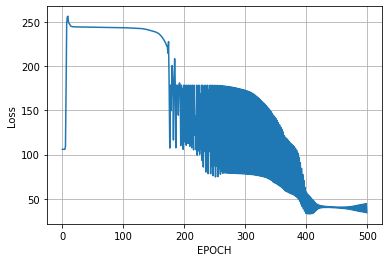

In [ ]:
plt.plot(list_loss)
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
y_pred = model.predict(X)
score = np.sum(y_pred == y)/X.shape[0]
print('accuracy = ',100*score,'%')

accuracy =  86.29173989455184 %


このように30個の特徴量データをすべて使ったとしても、学習率パラメータを適切に選び、学習曲線の挙動を調べながら学習させていくと、ある程度質の高い学習器を生成することは可能である。

## 工夫点と次回の意気込み

今回はirisデータの２つ以上の特徴量データを用いて、二値分類を行ってみた。今回、クラスの定義について学習し、本格的な機械学習分類器を作成することを頑張った。iris程度のデータだと、単層パーセプトロンの自作分類器でも正答率がしっかりと100%近くになってくれた。しかしながら、breast_cancerデータなどの特徴量次元が多くなると、学習器の性能が低下する。次元数30個でもちゃんと分類を行う分類器を作れるか自身はないが、次回以降に取り組めたらと思う。(そもそも30個も特徴量データを使わなくとも精度を出す方法がある...)